In [86]:
import json
import tensorflow as tf
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
!wget https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json

--2021-03-07 19:18:26--  https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6057046 (5.8M) [text/plain]
Saving to: ‘Sarcasm_Headlines_Dataset.json.1’

Sarcasm_Headlines_D 100%[===================>]   5.78M  --.-KB/s    in 0.1s    

2021-03-07 19:18:27 (40.5 MB/s) - ‘Sarcasm_Headlines_Dataset.json.1’ saved [6057046/6057046]



In [88]:
sentences =[]
labels = []

for line in open('Sarcasm_Headlines_Dataset.json', 'r').readlines():
  data = json.loads(line)
  sentences.append(data['headline'])
  labels.append(data['is_sarcastic'])

In [89]:
print(labels[:5], sentences[:5])

[1, 0, 0, 1, 1] ['thirtysomething scientists unveil doomsday clock of hair loss', 'dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes', 'inclement weather prevents liar from getting to work', "mother comes pretty close to using word 'streaming' correctly"]


In [90]:
x = []

sw = stopwords.words('english')

for sentence in sentences:
  sentence = sentence.lower()
  sentence = sentence.replace(",", " , ")
  sentence = sentence.replace(".", " . ")
  sentence = sentence.replace("-", " - ")
  sentence = sentence.replace("/", " / ")

  soup = BeautifulSoup(sentence)
  sentence = soup.get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    if word not in sw:
      filtered_sentence += word + " "
  x.append(filtered_sentence)

In [91]:
print(x[:5])
print(len(x))

['thirtysomething scientists unveil doomsday clock hair loss ', 'dem rep . totally nails congress falling short gender , racial equality ', 'eat veggies: 9 deliciously different recipes ', 'inclement weather prevents liar getting work ', "mother comes pretty close using word 'streaming' correctly "]
28619


In [92]:
training_size = 250000

x_train = x[:training_size]
y_train = labels[:training_size]

x_test = x[training_size:]
y_test = labels[training_size:]

In [123]:
vocab_size = 2500
maxlen = 18
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, padding='post', truncating=trunc_type, maxlen=maxlen)

OrderedDict([('new', 1658), ('trump', 1412), ('man', 1379), ('report', 604), ('one', 566), ('year', 541), ('day', 507), ('u', 506), ('area', 500), ('woman', 493), ('says', 484), ('donald', 473), ('time', 469), ('first', 467), ('like', 448), ('get', 423), ('old', 417), ("trump's", 403), ('life', 394), ('people', 392), ("'", 386), ('house', 379), ('still', 369), ('obama', 367), ('white', 366), ('back', 355), ('make', 351), ('women', 337), ('5', 315), ('clinton', 312), ('could', 311), ('world', 299), ('way', 296), ('americans', 288), ('family', 284), ('study', 277), ('would', 274), ('school', 263), ('gop', 262), ('black', 261), ('years', 259), ('bill', 257), ('finds', 252), ('really', 251), ('american', 248), ('best', 247), ('3', 247), ('last', 247), ('know', 245), ('police', 243), ('nation', 242), ("can't", 241), ('10', 238), ('going', 238), ('watch', 237), ('state', 235), ('death', 234), ('video', 230), ('home', 229), ('president', 228), ('good', 225), ('every', 224), ('say', 222), ('sh

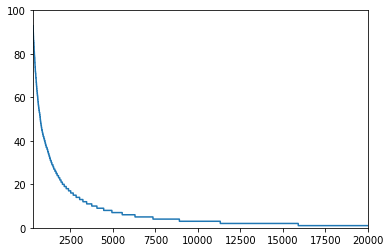

In [124]:
wc = tokenizer.word_counts
from collections import OrderedDict
from matplotlib import pyplot as plt
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(newlist)

xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])
plt.plot(xs,ys)
plt.axis([300,20000,0,100])
plt.show()

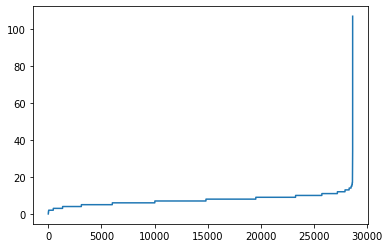

In [125]:
xs=[]
ys=[]
current_item=1
for item in x_train_seq:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)
import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [126]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, padding='post', truncating=trunc_type, maxlen=maxlen)

In [132]:
embed_dim = 8 # Embed dim = 4th root of vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.021)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.899, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 8)           20000     
_________________________________________________________________
global_average_pooling1d_13  (None, 8)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 20,081
Trainable params: 20,081
Non-trainable params: 0
_________________________________________________________________


In [133]:
import numpy as np
x_train_np = np.array(x_train_pad)
x_test_np = np.array(x_test_pad)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [134]:
history = model.fit(x_train_np,y_train_np, epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100
761/761 [==============================] - 3s 4ms/step - loss: 0.8666 - accuracy: 0.5175 - val_loss: 0.8206 - val_accuracy: 0.5281
Epoch 2/100
761/761 [==============================] - 3s 3ms/step - loss: 0.8076 - accuracy: 0.5296 - val_loss: 0.7725 - val_accuracy: 0.5304
Epoch 3/100
761/761 [==============================] - 3s 3ms/step - loss: 0.7631 - accuracy: 0.5354 - val_loss: 0.7382 - val_accuracy: 0.5318
Epoch 4/100
761/761 [==============================] - 3s 3ms/step - loss: 0.7319 - accuracy: 0.5393 - val_loss: 0.7147 - val_accuracy: 0.5327
Epoch 5/100
761/761 [==============================] - 3s 3ms/step - loss: 0.7113 - accuracy: 0.5383 - val_loss: 0.7002 - val_accuracy: 0.5353
Epoch 6/100
761/761 [==============================] - 3s 3ms/step - loss: 0.6984 - accuracy: 0.5413 - val_loss: 0.6921 - val_accuracy: 0.5358
Epoch 7/100
761/761 [==============================] - 3s 3ms/step - loss: 0.6917 - accuracy: 0.5454 - val_loss: 0.6884 - val_accuracy: 0.5411

In [135]:
def plot(history):
  from matplotlib import pyplot as plt
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


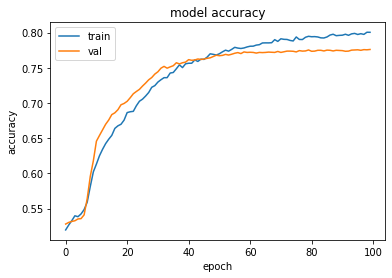

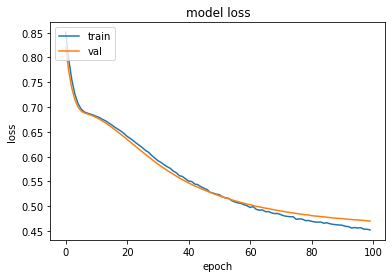

In [136]:
plot(history)

In [137]:
sentences = ["granny starting to fear spiders in the garden might be real",
"game of thrones season finale showing this sunday night",
"TensorFlow book will be a best seller"]

In [138]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 596, 1, 813, 1, 1, 1, 1, 273, 1, 112], [173, 1, 1, 174, 1, 2310, 1, 1539, 147], [1, 227, 1, 1, 1914, 47, 1]]


In [142]:
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen,
                      padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  596    1  813    1    1    1    1  273    1  112    0    0    0
     0    0    0    0]
 [ 173    1    1  174    1 2310    1 1539  147    0    0    0    0    0
     0    0    0    0]
 [   1  227    1    1 1914   47    1    0    0    0    0    0    0    0
     0    0    0    0]]


In [143]:
print(model.predict(padded))

[[0.617112  ]
 [0.4825221 ]
 [0.13726696]]


**Visualizing Latent Space**

In [144]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [145]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2500, 8)


In [146]:
print(reverse_word_index[2])
print(weights[2])

new
[-0.10238417 -0.23383564  0.2526863  -0.2469264  -0.23493174  0.21431865
  0.24873024 -0.25393358]


In [148]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

**Using  Pre-Trained Embedding from TF-HUB**

In [154]:
sentences =[]
labels = []

for line in open('Sarcasm_Headlines_Dataset.json', 'r').readlines():
  data = json.loads(line)
  sentences.append(data['headline'])
  labels.append(data['is_sarcastic'])

In [157]:
training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [165]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer(
  "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
  output_shape=[20], input_shape=[],
  dtype=tf.string, trainable=False
)

In [166]:
model2 = tf.keras.Sequential([
  hub_layer,
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [167]:
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_32 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [168]:
history = model2.fit(training_sentences,training_labels, validation_data=(testing_sentences, testing_labels) , epochs=100, batch_size=32)

Epoch 1/100
750/750 [==============================] - 3s 3ms/step - loss: 0.6893 - accuracy: 0.5474 - val_loss: 0.6384 - val_accuracy: 0.6389
Epoch 2/100
750/750 [==============================] - 2s 3ms/step - loss: 0.6424 - accuracy: 0.6326 - val_loss: 0.6252 - val_accuracy: 0.6553
Epoch 3/100
750/750 [==============================] - 2s 3ms/step - loss: 0.6261 - accuracy: 0.6531 - val_loss: 0.6184 - val_accuracy: 0.6633
Epoch 4/100
740/750 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.6623

KeyboardInterrupt: ignored

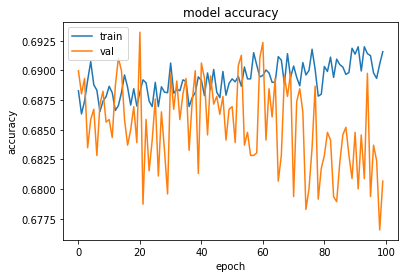

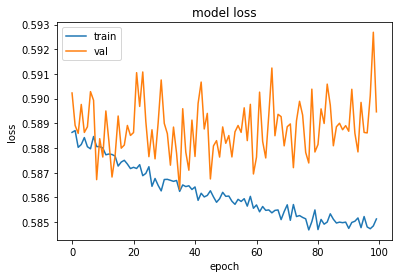

In [164]:
plot(history)